
### 라이브러리 import

In [ ]:
!pip install optuna
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## 전체 공통 함수

### 1. 데이터 보간 함수

- 데이터의 시간 간격을 0.5초의 등간격으로 맞추고 그에 따른 좌표 값을 보간함
- 가장 많이 사용되는 3차 스플라인 보간 적용

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# 데이터 보간 - 위도, 고도, 경도 값을 0.5초 시간 간격으로 보간
def spline_interpolation(x, y):
    # x: 보간할 데이터의 x 값 (시간)
    # y: 보간할 데이터의 y 값 (위도, 고도, 경도)

    # 3차 스플라인 보간 함수 생성
    f = interp1d(x, y, kind='cubic')

    # 시간 범위 설정
    start_time = min(x)
    end_time = max(x)

    # 0.5초 간격의 시간 배열을 생성
    new_x = np.arange(start_time, end_time, 0.5)

    # 위도, 경도, 고도 보간
    new_y = f(new_x)

    return new_x, new_y

### 2. 시퀀스 나누는 함수

- 학습을 위해 데이터를 시퀀스 형태로 나눔
- look back과 forward에 따라 학습에 사용될 x값의 구간과 y값을 반환함
- 초기 look back은 10, forward는 0이다.

In [ ]:
# 시퀀스 생성 함수
# look back : 10 (5초간의 위도, 고도, 경도 데이터를 x값으로 사용)
# forward : 0 (0.5초 뒤의 위도, 고도, 경도 데이터를 y값으로 사용)
def create_sequences(df, look_back=30, forward=3):
    xs = []
    ys = []
    for i in range(len(df) - look_back - forward):
        x = df.iloc[i:(i+look_back)].values
        y = df.iloc[i+look_back+forward].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### 3. 시간 소수점 절사 함수

- 불필요한 시간 소수점 제거

In [ ]:
import math

# 시간 소수점 절사 함수
def truncation(df):
    new_time = []

    for a in df['time']:
      new_time.append(math.floor(a * 10) / 10)

    df['time'] = new_time

    return df

### 4. 스케일링 함수

- MinMaxScaling 적용 함수


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaling 적용 함수
def min_max_scaling(df):

    # time 삭제 df 생성
    mid_df=df.drop(columns='time')

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(mid_df)

    min_max_data = min_max_scaler.transform(mid_df)

    new_data = pd.DataFrame(min_max_data)

    # time 추가
    new_data.insert(0, 'time', df['time'])

    # 나머지 열의 이름 가져오기
    column_names = mid_df.columns.tolist()

    column_names.insert(0, 'time')

    print(column_names)

    # 새로운 데이터프레임에 열 이름 설정
    new_data.columns = column_names

    return min_max_scaler, new_data

### 5. train/validation/test 분리 함수

- Train, Validation, Test 데이터셋을 분리하는 함수이다.
- 각각의 비율은 6:2:2 이다.

In [ ]:
from sklearn.model_selection import train_test_split

# train/validation/test 분리 함수
def split_train_val_test(df, test_size=0.2, val_size=0.25):

    #Train, Test 분류
    train_val_df, test_df = train_test_split(df, test_size=test_size, shuffle=False)

    #Train, Validation 분류
    train_df, val_df = train_test_split(train_val_df, test_size=val_size, shuffle=False)

    # # 데이터 크기 출력
    # print("Train set:", train_df.shape)
    # print("Validation set:", val_df.shape)
    # print("Test set:", test_df.shape)

    return train_df, val_df, test_df

### 6. 경로 시각화 함수

- 실제 경로와 예측 경로를 각각 그래프로 생성

In [ ]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def prediction_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯
    ax.scatter(y_test_lat, y_test_lon, y_test_alt, c='b', marker='o', label='Actual')

    # 예측 값 플롯
    ax.scatter(y_pred_lat, y_pred_lon, y_pred_alt, c='r', marker='^', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# splited 데이터 경로 시각화 함수
def plot_trajectory(train_data, val_data, test_data):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # 훈련 데이터 플롯
    ax.plot(train_data['lat'], train_data['lon'], train_data['alt'], label='Train', color='blue')

    # 검증 데이터 플롯
    ax.plot(val_data['lat'], val_data['lon'], val_data['alt'], label='Validation', color='green')

    # 테스트 데이터 플롯
    ax.plot(test_data['lat'], test_data['lon'], test_data['alt'], label='Test', color='red')

    # 그래프 레이블
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 제목과 범례
    ax.set_title('Drone Trajectory: Train, Validation, and Test')
    ax.legend()

    plt.show()


### 7. 데이터로더 생성 함수

- 학습에 사용할 데이터 로더 생성
1. 시퀀스 생성
2. Train, Validation, Test 분리
3. DataLoader 생성

In [ ]:
# 데이터 로더 생성 함수
def create_dataloaders(tri, batch_size, sequence_length):

  tri = tri[['time', 'lat', 'lon', 'alt']]

  # train, validation, test 분리
  train_data, val_data, test_data = split_train_val_test(tri)

  # 각 데이터셋에서 시퀀스 생성
  X_train, y_train = create_sequences(train_data[['lat', 'lon', 'alt']], look_back=sequence_length)
  X_val, y_val = create_sequences(val_data[['lat', 'lon', 'alt']], look_back=sequence_length)
  X_test, y_test = create_sequences(test_data[['lat', 'lon', 'alt']], look_back=sequence_length)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  validation_dataset = TensorDataset(X_val, y_val)
  test_dataset = TensorDataset(X_test, y_test)

  # 데이터 로더 생성
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

## 전처리

### 1. 데이터셋 가져오기

In [ ]:
import pandas as pd

# 데이터셋 가져오기 (필요시 저장 경로 수정)
raw = pd.read_csv("/content/OnboardGPS.csv")

### 2. 데이터셋 전처리

- 데이터셋 보간
- 소수점 절사
- MinMaxScaling 적용


In [ ]:
tri = raw[['Timpstemp', ' lat', ' lon', ' alt']]

new_x, lat = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lat'])
new_x, lon = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lon'])
new_x, alt = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' alt'])

tri = pd.DataFrame({"time":new_x, "lat":lat, "lon":lon, "alt":alt})

tri = truncation(tri)
scaler, tri = min_max_scaling(tri)
# tri

['time', 'lat', 'lon', 'alt']


## 모델 선언

### 1. 모델 클래스 선언
- Transformer를 사용한 모델 클래스 선언
- 구조 : Transformer + Positional Encoding + Fully Connected Layer

In [ ]:
import math
import torch

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.pe[:, 0::2] = torch.sin(position * div_term)  # Even indices

        self.pe = self.pe.unsqueeze(0)

    def forward(self, x):
        if self.pe.shape[2] != x.shape[2]:
            raise ValueError(f"Positional encoding dim {self.pe.shape[2]} does not match input dim {x.shape[2]}")

        x = x + self.pe[:, :x.size(1), :].to(x.device)  # Add positional encoding
        return self.dropout(x)

In [ ]:
import torch.nn as nn
import torch

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim=3, d_model=64, nhead=4, num_encoder_layers=2, dim_feedforward=512, dropout=0.0):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model, dropout=dropout)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model,
                                       nhead=nhead,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout,
                                       batch_first=True  # batch_first 사용
            ),
            num_layers=num_encoder_layers
        )

        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, src):
        # embedding과 positional encoding 적용
        src = self.embedding(src)
        src = self.positional_encoding(src)

        # transformer encoder 통과 (batch_first=True이므로 permute 필요 없음)
        output = self.transformer_encoder(src)

        # fully connected layer 통과
        output = self.fc_out(output)

        return output[:, -1, :]  # 마지막 시퀀스의 출력만 반환


## 학습

### 1. 하이퍼파라미터 불러오기

In [ ]:
import json

# 저장된 하이퍼파라미터 불러오기
with open("best_hyperparameters.json", "r") as f:
    best_params = json.load(f)

print("Loaded best hyperparameters:", best_params)

Loaded best hyperparameters: {'nhead': 5, 'd_model': 165, 'num_encoder_layers': 1, 'dim_feedforward': 384, 'learning_rate': 0.0007429501823161562, 'batch_size': 19}


### 2. 최적의 파라미터로 모델 학습

In [ ]:
sequence_length = 30
num_epochs = 632

In [ ]:
# 최적의 모델 학습
# best_params = study.best_params

train_loader, val_loader, test_loader = create_dataloaders(tri, best_params['batch_size'], sequence_length)

best_model = TransformerModel(
    input_dim=3,
    d_model=best_params['d_model'],
    nhead=best_params['nhead'],
    num_encoder_layers=best_params['num_encoder_layers'],
    dim_feedforward=best_params['dim_feedforward']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = torch.nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [ ]:
import time
import torch

# 학습 및 검증 손실을 기록할 리스트
train_losses = []
val_losses = []

best_model.train()
total_train_time = 0  # 총 학습 시간 기록 변수

for epoch in range(num_epochs):  # 최종 모델 학습
    best_model.train()
    train_loss = 0.0
    epoch_start_time = time.time()  # 에포크 시작 시간 기록
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = best_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    epoch_end_time = time.time()  # 에포크 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 한 에포크의 학습 시간
    total_train_time += epoch_duration  # 총 학습 시간에 추가

    # Validation set에서 성능 측정
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
            batch_y = batch_y.to(device)
            output = best_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()

    # 평균 손실 계산 및 저장
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 모델 저장
    if (epoch + 1) % 10 == 0 or epoch + 1 == 632:

      # Model Save
      model_save_path = f"/content/output_model/best_model_epoch_{epoch+1}.pth"
      torch.save({
        'model_state_dict': best_model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses
      }, model_save_path)
      print(f"Model saved: {model_save_path}")

    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")

print(f"Total training time: {total_train_time:.2f} seconds.")


Epoch [1/632], Train Loss: 1.3402, Val Loss: 0.0765
Epoch 1/632 completed in 1.51 seconds.
Epoch [2/632], Train Loss: 0.0552, Val Loss: 0.0183
Epoch 2/632 completed in 0.66 seconds.
Epoch [3/632], Train Loss: 0.0505, Val Loss: 0.0533
Epoch 3/632 completed in 0.65 seconds.
Epoch [4/632], Train Loss: 0.0445, Val Loss: 0.0261
Epoch 4/632 completed in 0.65 seconds.
Epoch [5/632], Train Loss: 0.0479, Val Loss: 0.0322
Epoch 5/632 completed in 0.66 seconds.
Epoch [6/632], Train Loss: 0.0519, Val Loss: 0.0257
Epoch 6/632 completed in 0.66 seconds.
Epoch [7/632], Train Loss: 0.0508, Val Loss: 0.0374
Epoch 7/632 completed in 0.78 seconds.
Epoch [8/632], Train Loss: 0.0432, Val Loss: 0.0356
Epoch 8/632 completed in 0.80 seconds.
Epoch [9/632], Train Loss: 0.0373, Val Loss: 0.0157
Epoch 9/632 completed in 0.99 seconds.
Epoch [10/632], Train Loss: 0.0598, Val Loss: 0.0139
Model saved: /content/output_model/best_model_epoch_10.pth
Epoch 10/632 completed in 1.27 seconds.
Epoch [11/632], Train Loss: 0

### 3. 모델 요약 내용 출력

In [ ]:
from torchinfo import summary

summary(best_model, (1, 10, 3), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModel                              [1, 3]                    --
├─Linear: 1-1                                 [1, 10, 165]              660
├─PositionalEncoding: 1-2                     [1, 10, 165]              --
│    └─Dropout: 2-1                           [1, 10, 165]              --
├─TransformerEncoder: 1-3                     [1, 10, 165]              --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 10, 165]              237,489
├─Linear: 1-4                                 [1, 10, 3]                498
Total params: 238,647
Trainable params: 238,647
Non-trainable params: 0
Total mult-adds (M): 0.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.52
Estimated Total Size (MB): 0.60

## 테스트

### 1. 테스트 결과 생성

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import time

# 모델 예측 및 성능 평가
best_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loss = 0
y_true_list = []
y_pred_list = []
total_correct = 0
total_samples = 0

threshold = 0.01  # Accuracy를 계산할 때 사용할 임계값 (오차 허용 범위)

start_time = time.time()  # 예측 시작 시간 기록

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 예측 수행
        output = best_model(batch_x)

        # 손실 계산
        loss = criterion(output, batch_y)
        test_loss += loss.item()

        # 예측값과 실제값 저장
        y_pred_list.append(output.cpu().numpy())  # 예측값을 CPU로 이동하여 numpy 배열로 변환
        y_true_list.append(batch_y.cpu().numpy())  # 실제값을 CPU로 이동하여 numpy 배열로 변환

        # Accuracy 계산 (오차가 threshold 이하인 경우 correct로 간주)
        y_pred_cpu = output.cpu().numpy()
        y_true_cpu = batch_y.cpu().numpy()
        correct = np.sum(np.linalg.norm(y_pred_cpu - y_true_cpu, axis=1) < threshold)
        total_correct += correct
        total_samples += len(batch_y)

end_time = time.time()  # 예측 종료 시간 기록

# 리스트를 numpy 배열로 변환
y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
accuracy = total_correct / total_samples

# 예측 시간 계산
prediction_time = end_time - start_time

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Total Prediction Time: {prediction_time:.4f} seconds')

Mean Squared Error (MSE): 0.0009586918167769909
Mean Absolute Error (MAE): 0.01975538767874241
Accuracy: 10.83%
Total Prediction Time: 0.0988 seconds


### 2. 결과 시각화

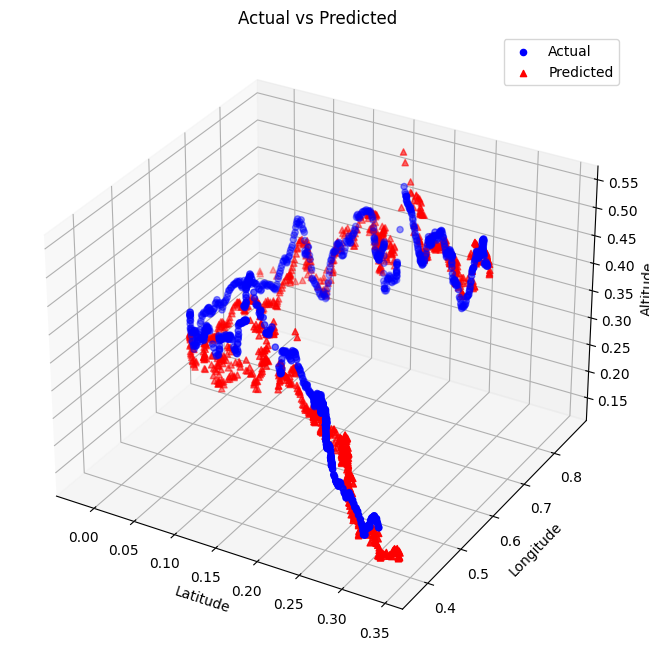

In [ ]:
prediction_visualization(y_true, y_pred)

#### 3. raw 데이터와 predict 데이터 비교

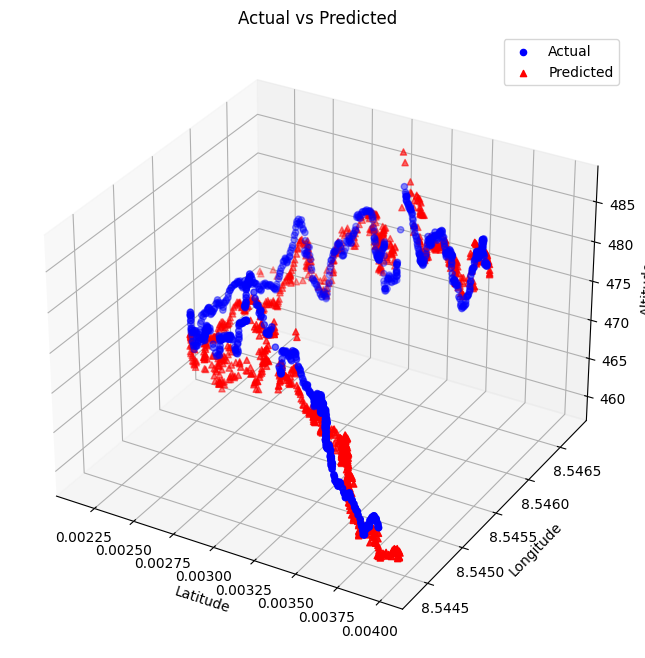

In [ ]:
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_true.reshape(-1, 3))

prediction_visualization(y_test_original, y_pred_original)

In [ ]:
# plot_trajectory(train_data, val_data, test_data)

## Compare Models


### Model 비교 그래프

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_model_comparison(df, num_epochs, y_limits = [0, 0.01]):

    # 그래프 설정
    if num_epochs == 50:
        xticks_interval = 10
    elif num_epochs == 100:
        xticks_interval = 20
    elif num_epochs == 150:
        xticks_interval = 30
    else:
        xticks_interval = num_epochs // 5  # 에포크 수에 따라 5개로 구분

    # 색상 지정
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Plot Train Loss
    axs[0].plot(df['epoch'], df['train_loss_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[0].plot(df['epoch'], df['train_loss_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[0].plot(df['epoch'], df['train_loss_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[0].set_title('Train Loss')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_xticks(range(0, num_epochs + 1, xticks_interval))  # x축 tick 설정
    axs[0].legend()
    axs[0].yaxis.grid(False)  # 가로줄 끄기
    axs[0].xaxis.grid(False)  # 세로줄 끄기

    # Y축 수동 설정
    if y_limits:
        axs[0].set_ylim(y_limits[0], y_limits[1])

    # Plot Valid Loss
    axs[1].plot(df['epoch'], df['valid_loss_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[1].plot(df['epoch'], df['valid_loss_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[1].plot(df['epoch'], df['valid_loss_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[1].set_title('Valid Loss')
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_xticks(range(0, num_epochs + 1, xticks_interval))
    axs[1].legend()
    axs[1].yaxis.grid(False)  # 가로줄 끄기
    axs[1].xaxis.grid(False)  # 세로줄 끄기

    # Y축 수동 설정
    if y_limits:
        axs[1].set_ylim(y_limits[0], y_limits[1])

    # Adjust layout
    plt.tight_layout()
    plt.show()

### 모델 불러오기

In [ ]:
checkpoint = torch.load('/content/output_model/best_model_epoch_632.pth')
print(checkpoint.keys())

transformer_train_losses = checkpoint['train_losses']
transformer_val_losses = checkpoint['val_losses']

# 손실 값 확인
# print(f"Train Losses: {transformer_train_losses[:5]}")
# print(f"Validation Losses: {transformer_val_losses[:5]}")

dict_keys(['model_state_dict', 'train_losses', 'val_losses'])


<ipython-input-28-485b378f7e82>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/output_model/best_model_epoch_632.pth')


### Val, Test data LOSS

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, y_limits=None):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))

    # Y축 수동 설정 (옵션)
    if y_limits:
        plt.ylim(y_limits[0], y_limits[1])

    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')

    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss per Epoch', fontsize=14)
    plt.legend()

    plt.grid(True)

    plt.tight_layout()
    plt.show()


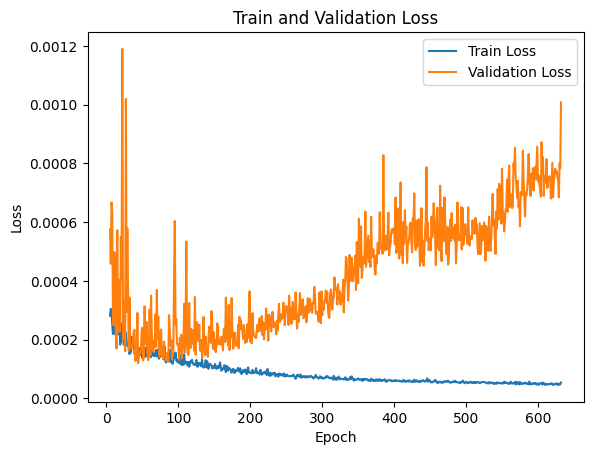

In [ ]:
plt.plot(range(5, num_epochs + 1), transformer_train_losses[4:], label='Train Loss')
plt.plot(range(5, num_epochs + 1), transformer_val_losses[4:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

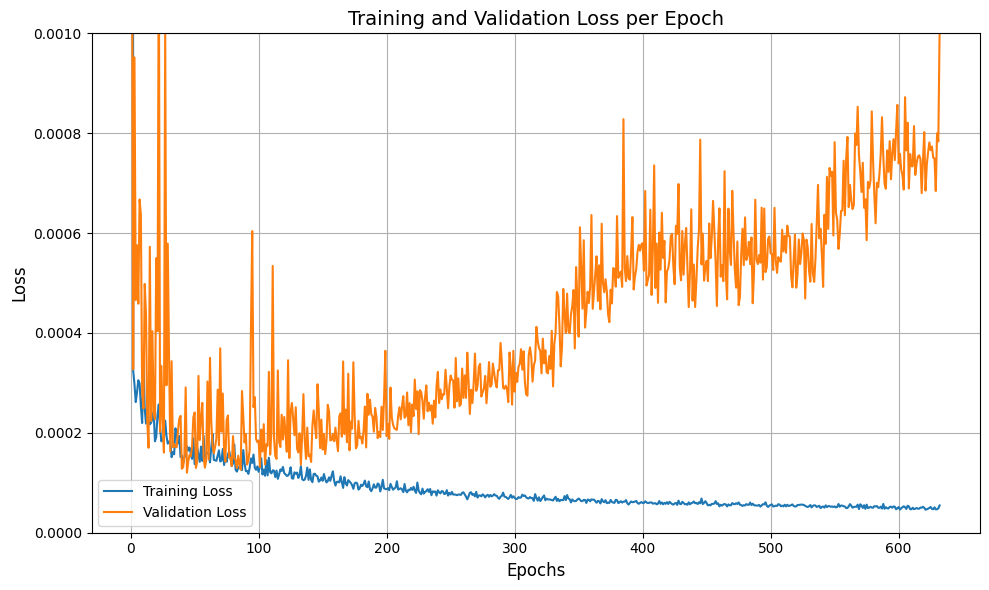

In [ ]:
plot_losses(transformer_train_losses, transformer_val_losses, y_limits = (0, 0.001))


In [ ]:
print("minimun", min(transformer_val_losses))

# val_losses = history['val_loss']
best_epoch = np.argmin(transformer_val_losses)  # 검증 손실이 가장 낮았던 epoch 찾기
print(f"Best epoch: {best_epoch}, Validation Loss: {transformer_val_losses[best_epoch]}")

minimun 0.00012022640755406298
Best epoch: 43, Validation Loss: 0.00012022640755406298


### 데이터 수집

In [ ]:
data = {
    'epoch': list(range(1, num_epochs + 1)),  # 실제 에포크 수만큼
    'train_loss_1': [x * 1.3 for x in train_losses],
    'train_loss_2': [x * 0.2 for x in train_losses],
    'train_loss_3': transformer_train_losses,
    'valid_loss_1': [x * 1.3 for x in val_losses],
    'valid_loss_2': [x * 0 for x in val_losses],
    'valid_loss_3': transformer_val_losses
}

### 모델 비교 그래프 그리기

In [ ]:
# df = pd.DataFrame(data)

# 그래프 그리기
# plot_model_comparison(df, num_epochs)